# ARE - ANIS LAPLAGNE

<p style='text-align: justify;'>
    <font color='green'>Nous précisons que ce notebook contient une version du projet NON FINALISEE dans le sens où certaines parties demandent encore un travail d'affinage et un ensemble de vérifications. Cependant, il contient l'essentiel du code qui sera utilisé en version finale, quant à la logique que nous avons adoptée pour tenter de résoudre ce problème difficile.</font>
</p>


# Rappel du sujet 
<p style='text-align: justify;'> Dans le cadre de cette étude, nous ambitionnons d’explorer les modalités comportementales d’un individu sous l’influence de son temps d’écran. Ces modalités sont représentées par trois variables fondamentales : l’ennui, la solitude et la productivité. L’ennui se manifeste comme la composante principale de l'ensemble des facteurs influençant les variations du temps d’écran. Les deux autres variables, quant à elles, jouent un rôle essentiel dans la modulation de l’ennui à travers une série d’interactions et de situations critiques. Une interaction peut se comprendre comme la production d'un résultat induit par des co-effets propres à un ensemble de variables étudiées. Ceci peut aussi tout aussi bien s'interpréter comme le résultat d'une conjonction simultanée de plusieurs variables descriptives du problème étudié. Précisons que chaque variable évolue dans un domaine défini, chaque domaine étant représenté par un ensemble de valeurs discrètes, décrivant, en un sens, une échelle de valeurs possibles pour la variable en question. Mentionnons enfin qu'il existe des valeurs critiques propres à chaque variable. Ce sont généralement des valeurs extrêmes du domaine relatif à la variable représentant des seuils, à partir desquels certains effets
critiques pourront apparaitre. Citons, comme exemple, qu'un temps d'écran supérieur ou égal à 15 heures par jour risque de produire des effets indésirables sur la santé, notamment en dégradant les vertus réparatrices du sommeil. </p>


# Chargement des packages et initialisations

In [1]:
import itertools
import math
import random

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

A des fins de personnalisation, on se propose de définir une petite fonction qui nous permet de construire des couleurs "originales"...


In [2]:
def rescale_color(*colors):
    col = np.asarray(tuple(colors)) / 255
    return col


MYLIGHTGREEN = rescale_color(24, 167, 69)
MYLAVENDE = rescale_color(113, 91, 192)
MYPINK = rescale_color(244, 112, 144)

MY_ORANGE = rescale_color(245, 73, 29)
MY_BLUE = rescale_color(38, 48, 151)
MY_BLUE2 = rescale_color(77, 122, 181)
MY_BACK = rescale_color(245, 245, 245)
MY_MAROON = rescale_color(157, 12, 12)
MY_GREEN = rescale_color(12, 108, 4)
MY_YELLOW = rescale_color(245, 240, 206)

<p style='text-align: justify;'> Les lignes qui suivent permettent de spécifier les valeurs d'un certain nombre de paramètres graphiques pour personaliser les tracés.</p>

In [3]:
mpl.rcParams.update(
    {
        "pgf.texsystem": "pdflatex",
        "font.family": "serif",
        "text.usetex": True,
        "pgf.rcfonts": False,
        "axes.spines.right": False,
        "axes.spines.top": False,
    }
)

# Définition des structures de données et des fonctions de haut niveau

## Variable `global_rules`

La variable `global_rules` représente une liste de tuples décrivants les interactions décritent en page 2 du document. Il s'agit de __toutes les règles__ qui ont été identifiées en première instance. Il n'est pas exclus qu'il en manque, ou que certaines doivent être affinées. Ce sera un des points à vérifier. A titre de rappel, le tuple `('p+', 'e-')` représente l'implication $\textrm{p+} \Longrightarrow \textrm{e-}$, i.e., lorsque le niveau de production hors activité connexe aux réseaux sociaux augmente, alors l'ennui diminue.


In [4]:
global_rules = [
    ("p+", "e-"),
    ("p-", "e+"),
    ("p0", "e0"),
    ("e+", "s+"),
    ("e-", "s-"),
    ("e0", "s0"),
    ("e+", "t+"),
    ("e-", "t-"),
    ("e0", "t0"),
    ("p+", "t-"),
    ("p-", "t+"),
    ("p0", "t0"),
]

## Fonction `generate_state`

Cette fonction se charge de construire un état possible, représenté par un quadruplet $[e^\varepsilon,s^\varepsilon,t^\varepsilon,p^\varepsilon]$ où $\varepsilon\in\{0, +,-\}$. Cet état est construit de façon aléatoire via la fonction `random.choices`, dont nous donnerons plus de détails dans la version finale du projet. Dans le cas présent, le tirage se fait selon une loi uniforme.

In [5]:
# Génération d'un état possible
def generate_state():
    return list(
        map(
            lambda x: str(x[0] + x[1]),
            list(zip(["e", "s", "t", "p"], random.choices(["-", "0", "+"], k=4))),
        )
    )

## Fonction `generate_rules_from_state`

Cette fonction se charge de construire toutes les implications possibles depuis un état généré. En somme, elle construit toutes les règles d'interactions possibles - au sens de la page 2 du document de référence - que l'on peut obtenir depuis un état. Par exemple, supposons que l'état en cours soit `si = ['e+', 's+', 't0', 'p0']`. L'appel `generate_rules_from_state(si)` fournit les résulats suivants:
<p style='text-align: center;'>
[('e+', 's+'),
 ('e+', 't0'),
 ('e+', 'p0'),
 ('s+', 'e+'),
 ('s+', 't0'),
 ('s+', 'p0'),
 ('t0', 'e+'),
 ('t0', 's+'),
 ('t0', 'p0'),
 ('p0', 'e+'),
 ('p0', 's+'),
 ('p0', 't0')]
</p>

En d'autres termes, il s'agit de générer toutes les permutations à deux éléments parmi quatre possibles. La formule générale d'obtention des permutations à $p$ éléments parmi $n$ possibles est $\displaystyle{p!\binom{n}{p}}$. Dans notre cas, nous aurons un total de $\displaystyle{2!\binom{4}{2}}=12$ possibilités.

Afin de simplifier les codes, nous utiliserons la fonction `permutations` du package `itertools` pour construire notre liste d'implications.



In [6]:
# Fonction generate_rules_from_state
def generate_rules_from_state(state):
    return list(itertools.permutations(state, 2))

## Fonction `generate_action`

Cette fonction est sans doute la plus délicate à coder du projet. Dans ce cadre, nous allons tenter d'être le plus exhaustif possible afin d'en fournir une explication complète. Notons que cette fonction fait appel à deux fonctions locales dont les productions seront détaillées un peu plus loin.

Les paramètres de la fonction sont `rule` et `bump_value`. 

- `rule` décrit une règle (une implication) sous la forme d'un tuple tel que décrit plus haut;
- `bump_value` est la valeur positive qui devra être appliquée à une coordonnée d'un état en cours. Rappelons qu'un état est un quadruplet $(e,s,t,p)$ valant, par exemple $(1,2,1,4)$ à un instant d'observation $t_i$, $i=0,\cdots,N$, où $N$ est l'horizon de la période d'étude (par exemple, $N$=30 jours).

Ceci étant posé, la fonction commence par analyser chaque composante du tuple représentant la règle passée en paramètre. Pour chaque composante, on extrait la __lettre__ et le __signe__. Comme on considère qu'un état est toujours construit selon l'ordre $(e,s,t,p)$, nous allons donc appeler la fonction locale `get_index_from` qui, en fonction de la lettre passée en paramètre, renverra son indice dans le quadruplet d'état. Par exemple, l'appel `get_index_from('e')`renverra 0 puisque la modalité $e$ se trouve en première position dans le quadruplet. De même, `get_index_from('p')` renverra 3, etc...

Ensuite, nous appelons la fonction `get_action_from` qui, en fonction du signe passé en paramètre, renvoie l'action à appliquer à une modalité. Pour le moment, cette action est une __quantité signée__  à appliquer de façon __additive__ à une modalité. Elle est définie de la façon suivante:

- Si le signe vaut '0' : alors aucune action n'est à appliquer, et `action = 0`;
- Si le signe vaut '+' : alors l'action à appliquer vaut `action = +bump_value`;
- Si le signe vaut '-' : alors l'action à appliquer vaut `action = -bump_value`.

Nous allons donc construire un quadruplet $Q_c=(i_1,a_1,i_2,a_2)$, où $i_1,i_2$ représentent les indices de l'état en cours qui devrons être modifiés par les actions $a_1,a_2$. Ainsi, en initialisant un quadruplet de dimension 4 à zéro, que l'on notera $Q_0=[0,0,0,0]$ (il s'agit d'une liste de sorte que les coordonnées puissent être modifiées), il suffira alors de construire le vecteur de chocs à appliquer à l'état en cours de la façon suivante:

\begin{align*}
Q_0[Q_c[0]]&\textrm{ += } Q_c[1]\\
Q_0[Q_c[2]]&\textrm{ += } Q_c[3]
\end{align*}

Illustrons tout ceci sur un exemple. Supposons l'appel suivant : `generate_action(("e+", "p-"), 1)`. Voici les différentes productions du corps de la fonction :

- Première partie :
 ```python
    letter_p, sign_p = rule[0][0], rule[0][1] # letter_p = "e" et sign_p = "+"
    letter_c, sign_c = rule[1][0], rule[1][1] # letter_c = "p" et sign_c = "-"
```
- Seconde partie :
```python
    to_do = (
        get_index_from(letter_p),
        get_action_from(sign_p),
        get_index_from(letter_c),
        get_action_from(sign_c),
    ) # Ici, to_do = (0,1,3,-1)
```
- Troisième partie :
 ```python
    state_shift = [0] * 4               # state_shift = [0,0,0,0]
    
    state_shift[to_do[0]] += to_do[1]   # state_shift = [1, 0, 0,  0]
    state_shift[to_do[2]] += to_do[3]   # state_shift = [1, 0, 0, -1]

  ```

Finalement, la fonction renvoie le vecteur de choc $c_t=[1, 0, 0, -1]$ qui sera appliqué à l'état en cours. Supposons que l'état en cours $s_t$ vaille $s_t=[2,2,3,1]$, alors le nouvel état au temps $t+1$ sera $s_{t+1}=s_t+c_t=[3,2,3,0]$


In [7]:
def generate_action(rule, bump_value):
    def get_index_from(state_letter):
        idx = 0
        match state_letter:
            case "e":
                idx = 0
            case "s":
                idx = 1
            case "t":
                idx = 2
            case "p":
                idx = 3
        return idx

    def get_action_from(sign_letter):
        action = 0
        match sign_letter:
            case "0":
                action = 0
            case "+":
                action = bump_value
            case "-":
                action = -bump_value
        return action

    letter_p, sign_p = rule[0][0], rule[0][1]
    letter_c, sign_c = rule[1][0], rule[1][1]

    to_do = (
        get_index_from(letter_p),
        get_action_from(sign_p),
        get_index_from(letter_c),
        get_action_from(sign_c),
    )

    state_shift = [0] * 4

    state_shift[to_do[0]] += to_do[1]
    state_shift[to_do[2]] += to_do[3]

    return state_shift

## Fonction `bound_values`

Dans la mesure où l'on considère que les modalités d'un état varient dans des intervalles de valeurs de type $[\![ m^-;m^+]\!]$, où $m^-$ et $m^+$ représentent les valeurs minimale et maximale respectivement que peut prendre la modalité $m$, on se propose de borner les valeurs d'une modalité dans cet intervalle. Mathématiquement, cela revient à définir la fonction $\phi_{m^-,m^+}:x\in\mathbb{R}\mapsto \max(m^-,\min(m^+, x))$, puis à l'appliquer sur la valeur d'une modalité d'un état. Dans notre code, cette fonction est définie ci-dessous.

In [8]:
def bound_values(a, b, x):
    return np.maximum(a, np.minimum(b, x))

## Fonction `update_state`

Cette fonction gère simplement l'addition de deux vecteurs. Cela permet de modifier un état en lui additionnant un vecteur de choc, comme expliqué plus haut. Notons que nous appliquons sur chaque coordonnée du nouvel état la fonction `bound_value` afin de s'assurer que les valeurs des modalités appartiennent à des intervalles de valeurs admissibles. Dans notre cas, nous faisons le choix de définir un état en modalités exprimées en "probabilités". C'est la raison pour laquelle nous bornons nos valeurs entre 0 et 1.

In [9]:
def update_state(state, action):
    tmp = list(sum(xy) for xy in zip(state, action))
    return list(map(lambda x: bound_values(0, 1, x), tmp))

# Boucle principale de simulation

A présent, l'idée est de générer un certain nombre de simulations pour observer comment évolue un état initialialement fixé à certaines valeurs de modalité. Il y aura beaucoup à dire du code ci-dessous dans la version finale du document, et nous nous proposons, dans un premier temps, d'exposer les graphiques des évolutions des modalités dans le temps (horizon 60 jours, soit deux mois) et pour chaque simulation (nombre de simulation fixé à 10000).

A cet effet, nous fixons les hypothèses suivantes :

- L'état initial est toujours le même pour toutes les simulations. On le choisi de sorte que :
    -  l'ennui, la solitude, le temps d'écran soient minimaux;
    -  La productivité soit maximale.

Compte tenu des règles définies, nous conjecturons que les trois premières modalités risquent d'augmenter, alors que la quatrième risque de baiser. Ceci est une intuition qui correspond au fait que la productivité peut potentiellement se faire "pervetir" par les autres facteurs.

Nous n'avons pas encore tester d'autres hypothèses comme le fait de faire varier l'amplitude des chocs, de rendre ces derniers asymétriques (avec des valeur non égales en valeur absolue), de tester l'impact de chocs multiplicatifs et non additifs, ainsi que bien d'autres idées que nous exposerons ultérieurement.

In [10]:
all_simulations = []
NB_DAYS = 30 * 2
NB_SIMULATION = 10_000

for _s in tqdm(range(NB_SIMULATION)):
    current_state_values = np.array([0.001, 0.001, 0.001, 0.80])
    current_state_values = current_state_values / sum(current_state_values)
    states = []
    for _p in range(NB_DAYS):
        state_i = generate_state()
        generated_rules = generate_rules_from_state(state_i)

        for rule in generated_rules:
            if rule in global_rules:
                ga = generate_action(rule, 1 / (NB_DAYS - 1))
                current_state_values = update_state(current_state_values, ga)
        states.append(current_state_values)
    all_simulations.append(states)

simulations = np.array(all_simulations)

  0%|          | 0/10000 [00:00<?, ?it/s]

Voic les graphiques annoncés:

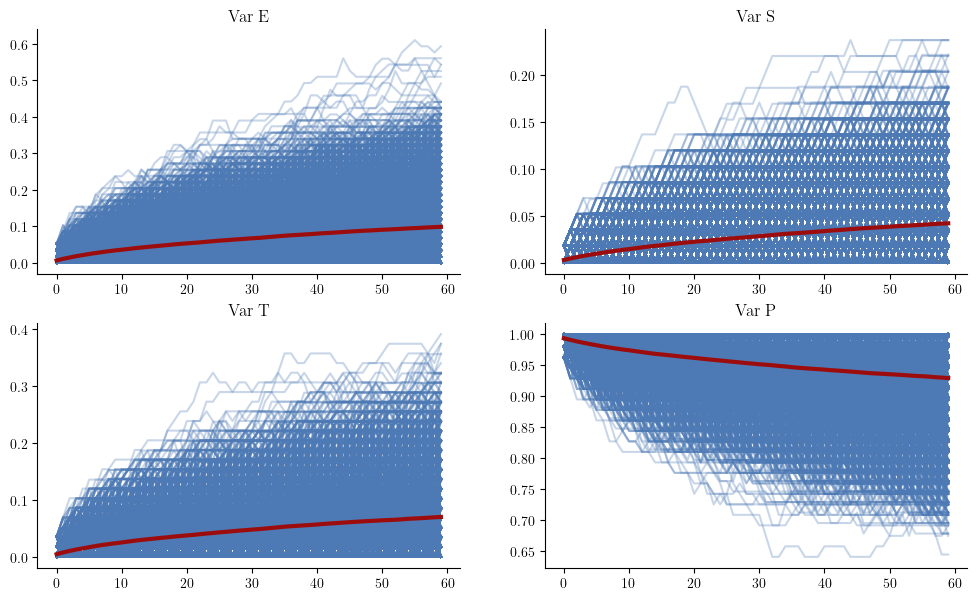

In [11]:
fix, ax = plt.subplots(2, 2, figsize=(12, 7))
idx = 0
ax[0, 0].plot(simulations[:, :, idx].T, color=MY_BLUE2, alpha=0.3)
ax[0, 0].plot(simulations[:, :, idx].mean(axis=0), lw=3, color=MY_MAROON)
ax[0, 0].set_title("Var E")

idx = 1
ax[0, 1].plot(simulations[:, :, idx].T, color=MY_BLUE2, alpha=0.3)
ax[0, 1].plot(simulations[:, :, idx].mean(axis=0), lw=3, color=MY_MAROON)
ax[0, 1].set_title("Var S")

idx = 2
ax[1, 0].plot(simulations[:, :, idx].T, color=MY_BLUE2, alpha=0.3)
ax[1, 0].plot(simulations[:, :, idx].mean(axis=0), lw=3, color=MY_MAROON)
ax[1, 0].set_title("Var T")

idx = 3
ax[1, 1].plot(simulations[:, :, idx].T, color=MY_BLUE2, alpha=0.3)
ax[1, 1].plot(simulations[:, :, idx].mean(axis=0), lw=3, color=MY_MAROON)
ax[1, 1].set_title("Var P")

plt.show()

Sans proposer d'analyses fines, on observe que nos intuitions se confirment par les graphiques ci-dessus. Les courbes épaisses de couleur foncée correspondent aux trajectoires moyennes des modalités conditionnellement aux 10000 simulations. On observe assez clairement les tendances anticipées.

# Conclusions

<p style='text-align: justify;'>Pour finir ce bref exposé, nous rappelons ici que rien n'est figé dans le marbre, et que beaucoup d'évolutions sont envisagées. Cependant, à des fins d'exposé simplifié, nous avons choisi une première approche permettant d'illustrer nos idées, et de disposer d'une base de discusions pour la suite.
</p>

<p style='text-align: right;'>
    Anis Laplagne, le 30 mars 2024
</p>
